In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
DATA_DIRECTORY = os.path.join("..","input","optiver-realized-volatility-prediction")
TRADE_TRAIN_DIRECTORY = os.path.join(DATA_DIRECTORY,"trade_train.parquet")
TRADE_TEST_DIRECTORY = os.path.join(DATA_DIRECTORY,"trade_test.parquet")
BOOK_TRAIN_DIRECTORY = os.path.join(DATA_DIRECTORY,"book_train.parquet")
BOOK_TEST_DIRECTORY = os.path.join(DATA_DIRECTORY,"book_test.parquet")
OUTPUT_DIRECTORY = os.path.join("..","output")
os.makedirs(OUTPUT_DIRECTORY,exist_ok=True)

In [3]:
train_df = pd.read_csv(os.path.join(DATA_DIRECTORY,"train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIRECTORY,"test.csv"))

### Train data has stock_id, time_id, target: 127 stocks, all of the stock has multiple timeid

In [4]:
train_df

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


- each stock has 3830 rows for time_id, that shows the way these optiver folks generated the data
- for each stock they broke it down to fixed windows

In [5]:
train_df.groupby("stock_id").count()

,time_id,target
stock_id,,
0,3830,3830
1,3830,3830
2,3830,3830
3,3830,3830
4,3830,3830
...,...,...
122,3830,3830
123,3830,3830
124,3830,3830


### the difference between time slices is odd; that proves that regardless of the span of data available to optiver they simply broke with number of windows rather than windows size; 
### WAIT, mybad it's just ID, maybe those id just points to some row; and it might be that different stocks have different seconds for each timeframe; makes sense as not all the time trade happens; and this is tick data so if no one changes orderbook then the two ticks might have minutes of difference while otherplace where lot of liquidity is there can have ticks with only a second difference(hence high number of time ids)
- window size is varying
- windows are fixed 3830

<AxesSubplot:>

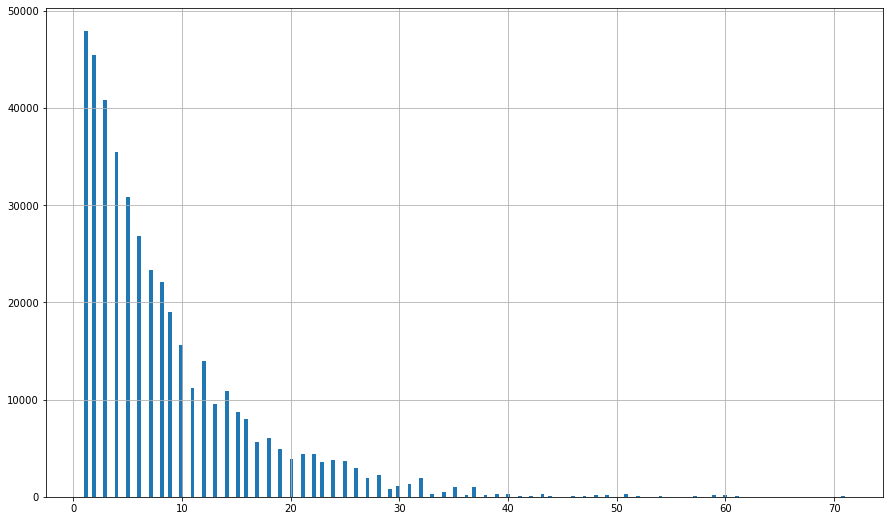

In [6]:
train_df.groupby("stock_id").diff()["time_id"].hist(bins=200, figsize=(15,9))

In [7]:
sample_stock_id = 51
sample_trade_df = pd.read_parquet(os.path.join(DATA_DIRECTORY, "trade_train.parquet", f"stock_id={sample_stock_id}"))
sample_book_df = pd.read_parquet(os.path.join(DATA_DIRECTORY, "book_train.parquet", f"stock_id={sample_stock_id}"))

In [8]:
sample_book_df

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001266,1.001434,1.001097,1.001603,107,100,600,101
1,5,1,1.001603,1.001940,1.001434,1.002109,100,300,500,223
2,5,2,1.001603,1.001940,1.001434,1.002109,100,101,400,119
3,5,3,1.001603,1.001940,1.001434,1.002109,100,1,400,119
4,5,4,1.001603,1.001940,1.001434,1.002109,200,300,400,101
...,...,...,...,...,...,...,...,...,...,...
1703706,32767,595,1.001829,1.002121,1.001682,1.002268,500,400,700,400
1703707,32767,596,1.001682,1.001975,1.001536,1.002121,600,300,400,500
1703708,32767,597,1.001829,1.002121,1.001682,1.002268,500,300,500,400
1703709,32767,598,1.001975,1.002121,1.001829,1.002268,100,300,500,400


In [9]:
sample_trade_df

,time_id,seconds_in_bucket,price,size,order_count
0,5,1,1.001659,601,8
1,5,16,1.001535,506,10
2,5,19,1.001434,7,1
3,5,22,1.001434,134,2
4,5,32,1.001434,98,1
...,...,...,...,...,...
301381,32767,555,1.001682,199,1
301382,32767,558,1.001536,400,3
301383,32767,584,1.001646,400,2
301384,32767,588,1.001829,40,1


### We need to figure out what is the seconds in bucket time

In [10]:
sample_book_df.groupby("time_id")['seconds_in_bucket'].count().max()

599

In [11]:
sample_book_df[sample_book_df['time_id']==32751]

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
1701573,32751,0,0.999925,1.000226,0.999774,1.000377,54,200,200,145
1701574,32751,4,0.999925,1.000226,0.999774,1.000377,54,100,200,145
1701575,32751,7,0.999925,1.000226,0.999774,1.000377,54,100,200,245
1701576,32751,11,0.999925,1.000226,0.999774,1.000377,154,100,200,245
1701577,32751,13,0.999925,1.000226,0.999774,1.000377,154,95,200,245
...,...,...,...,...,...,...,...,...,...,...
1701946,32751,590,0.999321,0.999623,0.999170,0.999774,920,249,100,121
1701947,32751,591,0.999321,0.999623,0.999170,0.999774,920,49,100,220
1701948,32751,592,0.999472,0.999623,0.999321,0.999774,200,49,900,120
1701949,32751,593,0.999472,0.999623,0.999321,0.999774,100,125,900,120


### book size is 10 minutes! checks out

In [12]:
sample_trade_df.groupby("time_id")['seconds_in_bucket'].apply(lambda x: (x.iloc[-1] - x.iloc[0])/60)

time_id
5        9.850000
11       9.216667
16       9.850000
31       9.800000
62       9.400000
           ...   
32751    9.700000
32753    9.316667
32758    9.216667
32763    9.950000
32767    9.916667
Name: seconds_in_bucket, Length: 3830, dtype: float64

### how does the prices of book vs trade compare

In [18]:
def log_diff(df, in_col, null_val):
    df["logx"] = df[in_col].log()
    df["logx_shifted"] = (df[["time_id", "logx"]].groupby("time_id")
                             .apply_grouped(cutran.get_cu_shift_transform(shift_by=1, null_val=null_val),
                                            incols={"logx": 'x'},
                                            outcols=dict(y_out=cp.float32),
                                            tpb=32)["y_out"])
    df["keep_row"] = df[f"logx_shifted"] != null_val
    return df["logx"] - df["logx_shifted"]
def populate_volume(df):
    df[f'total_volume'] = df['bid_size1'] + df['bid_size2'] + df['ask_size1'] + df['ask_size2']
    df[f'bid_size'] = df['bid_size1'] + df['bid_size2']
    df[f'ask_size'] = df['ask_size1'] + df['ask_size2']
        

def populate_wap(df):
    for n in range(1, 3):
        p1 = df[f"bid_price{n}"]
        p2 = df[f"ask_price{n}"]
        s1 = df[f"bid_size{n}"]
        s2 = df[f"ask_size{n}"]
        df[f"wap{n}"] = (p1*s2 + p2*s1) / (s1 + s2)
# figure out wap first

#     sample_book_df[f"log_return{n}"] = log_diff(sample_book_df, in_col=f"wap{n}", null_val=-9999)
#     sample_book_df[f"realized_vol{n}"] = sample_book_df[f"log_return{n}"]**2

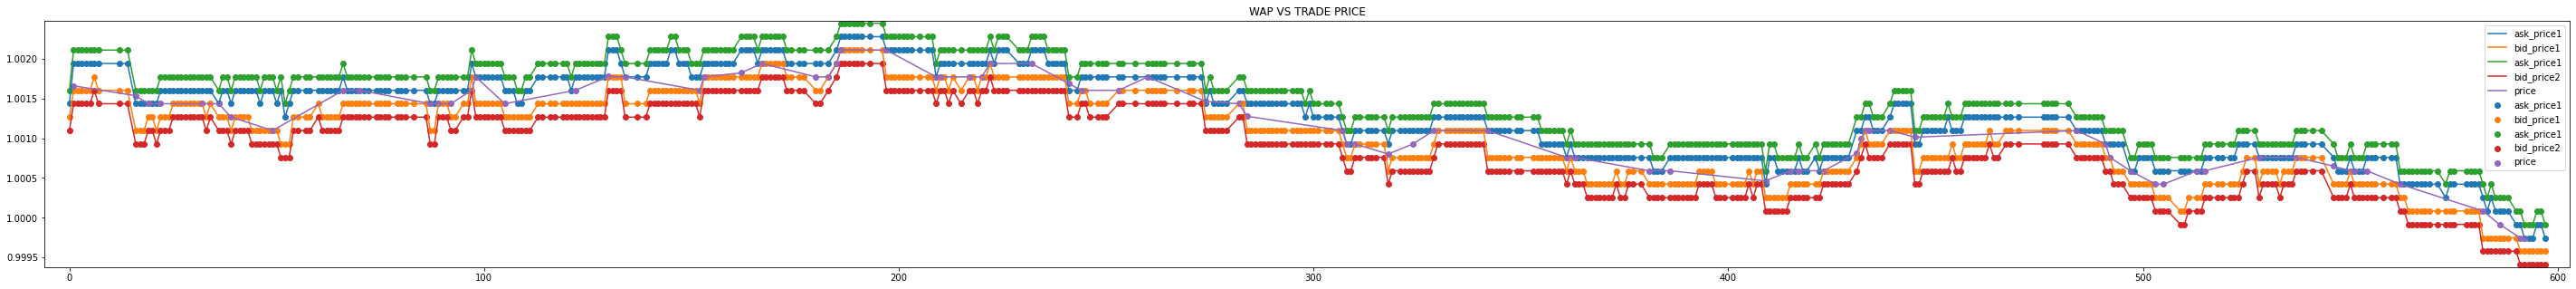

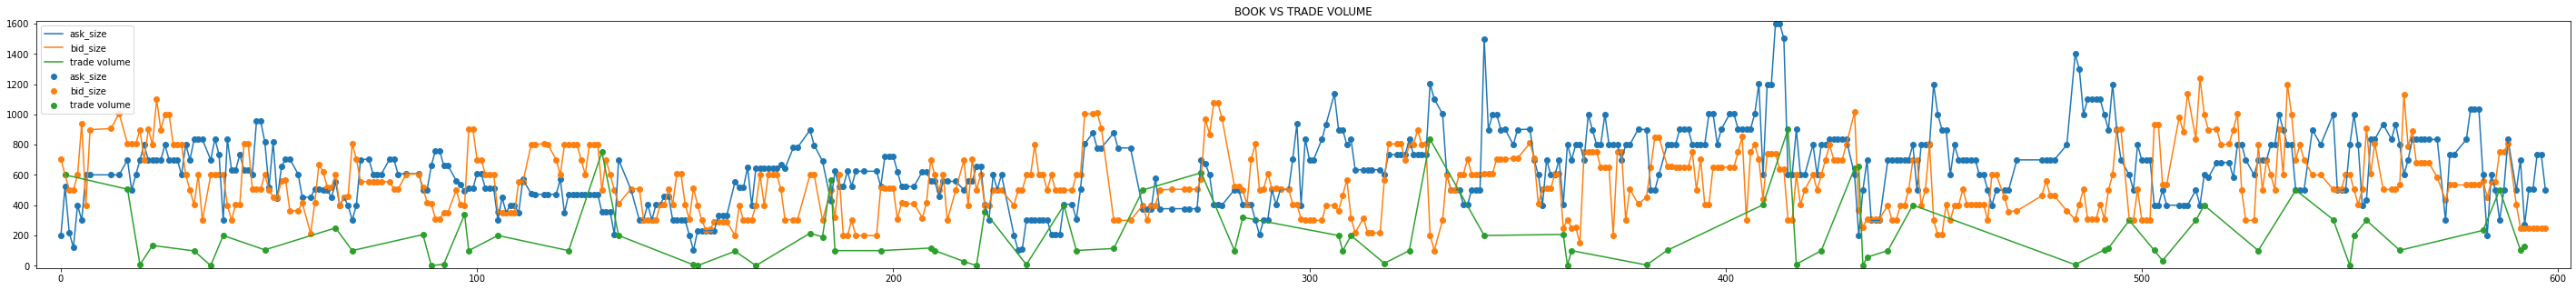

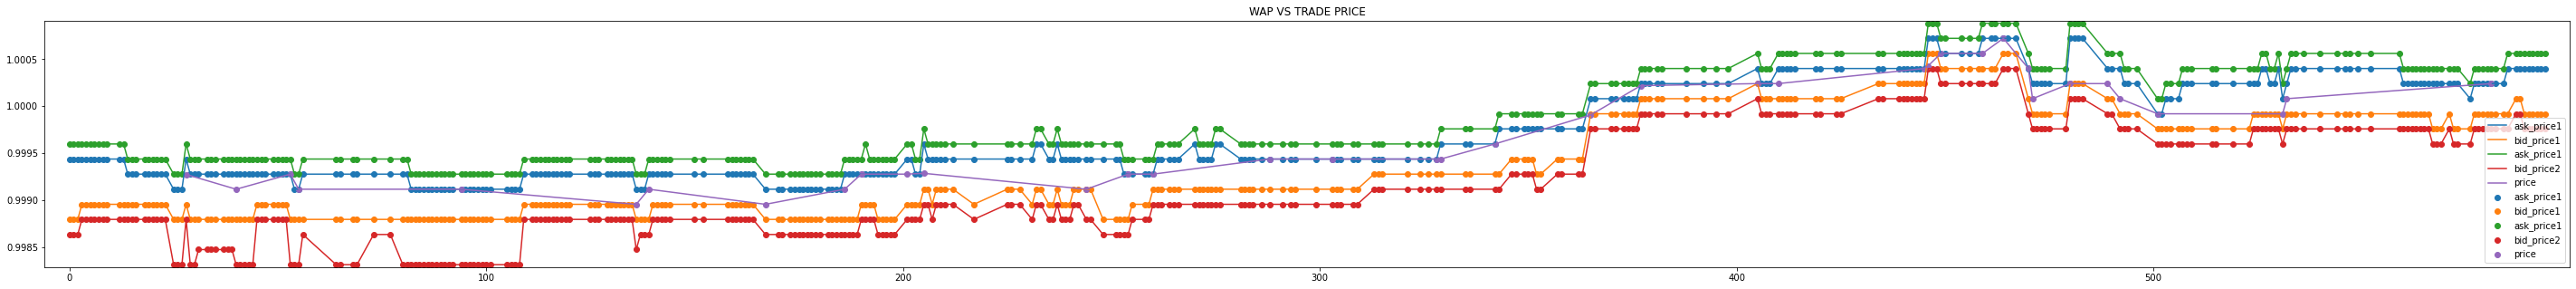

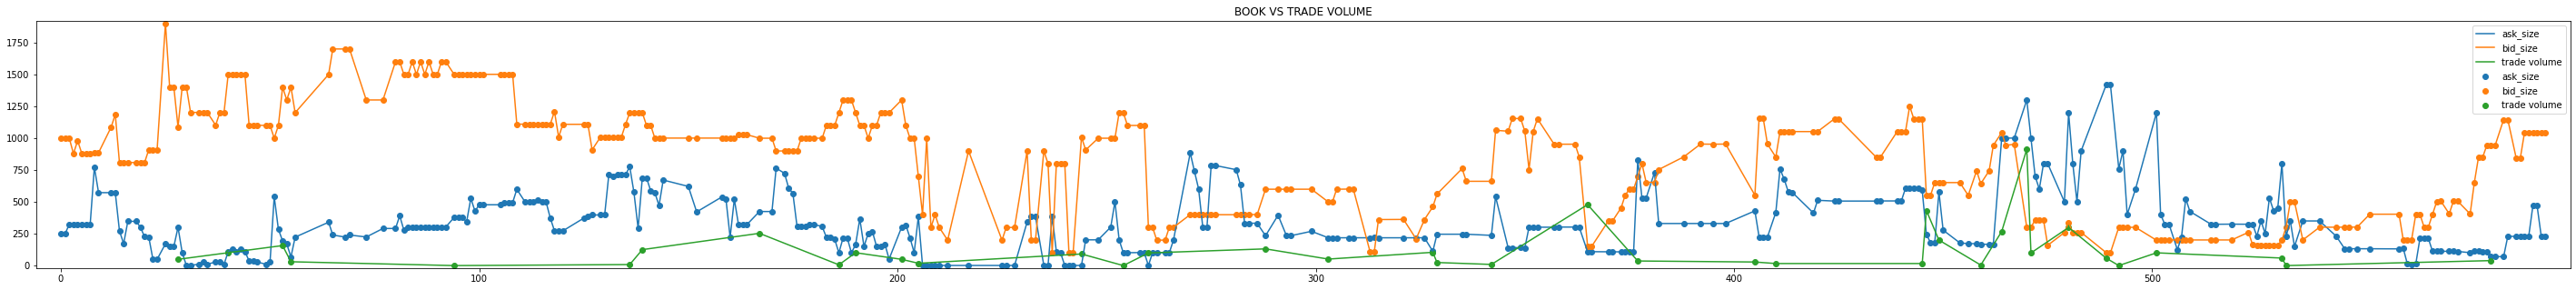

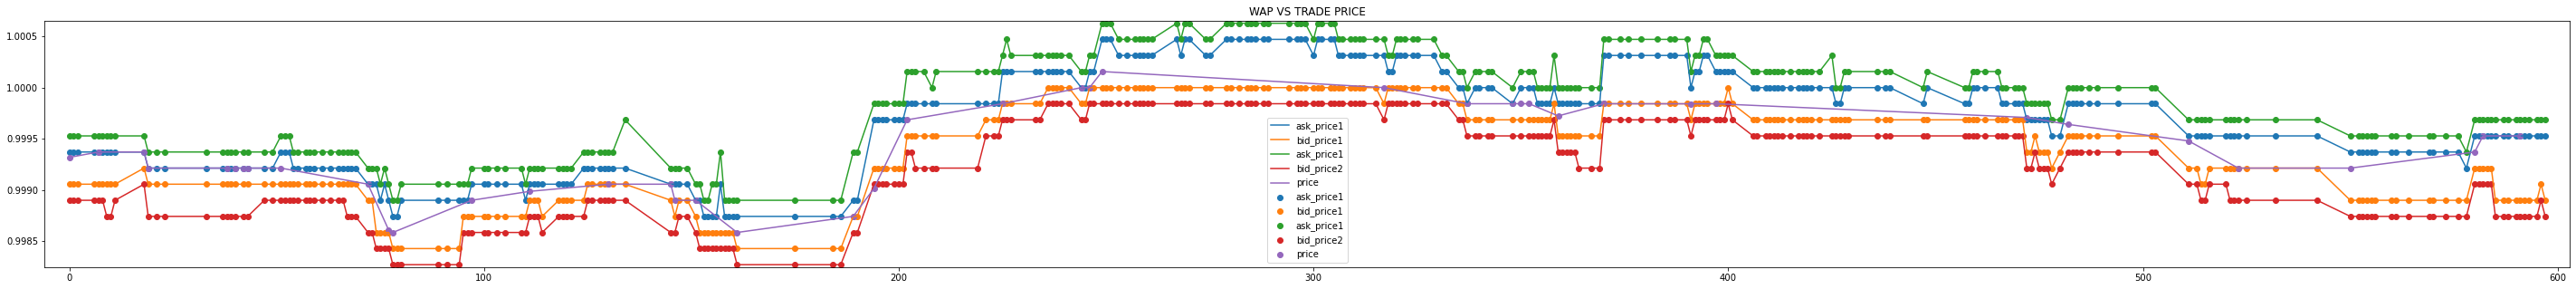

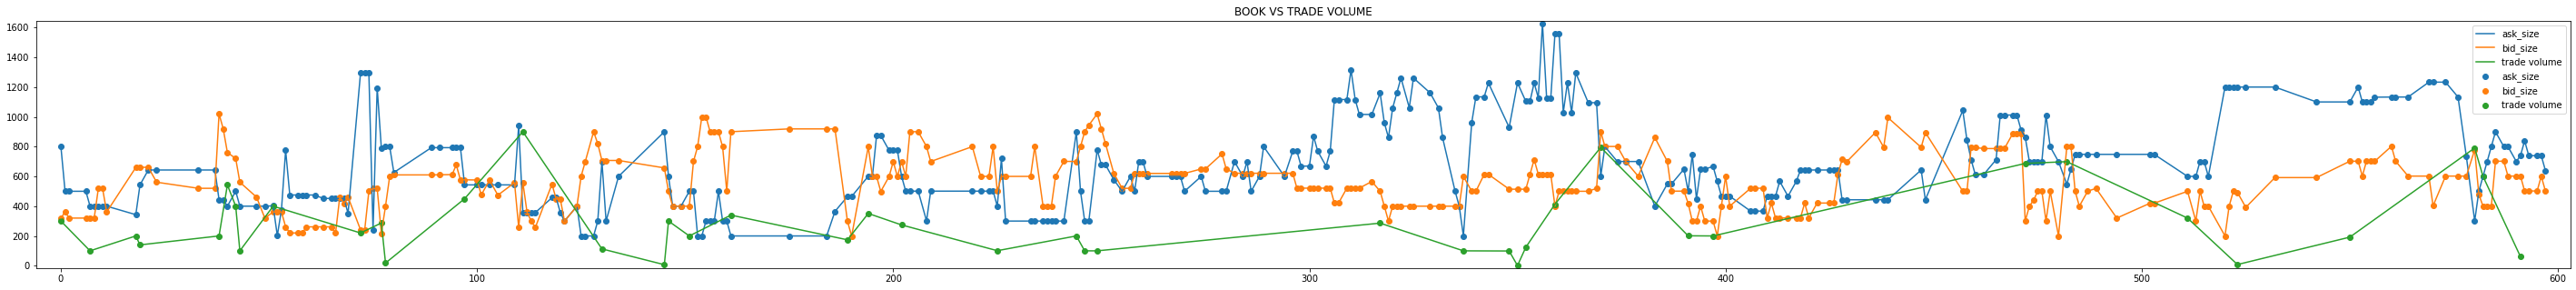

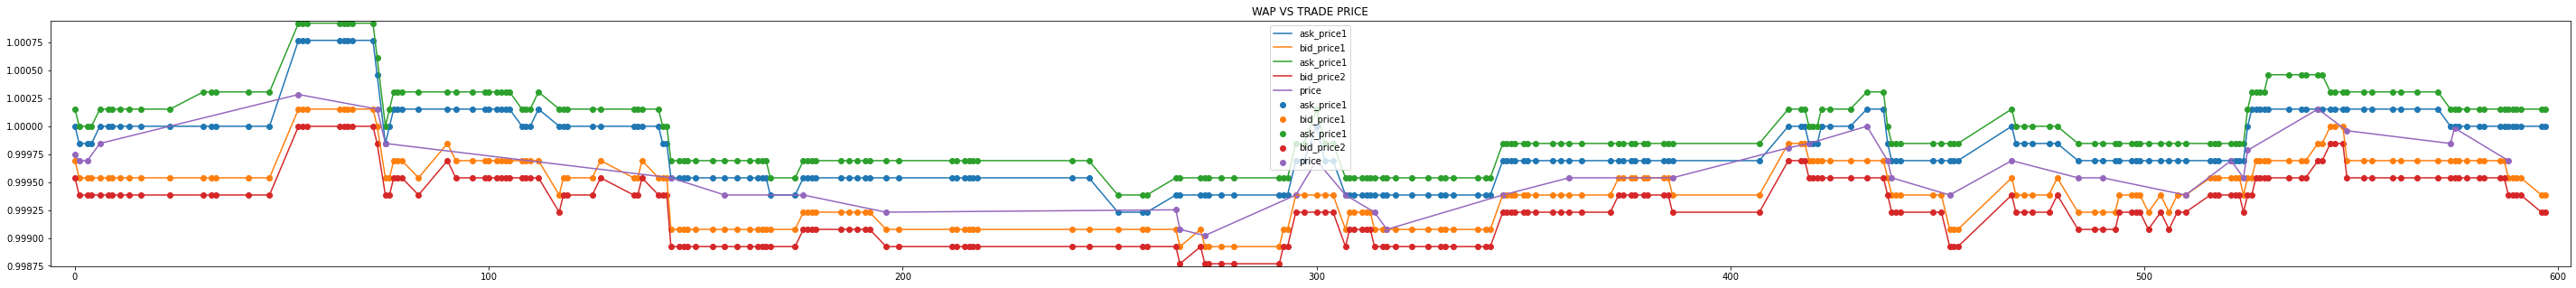

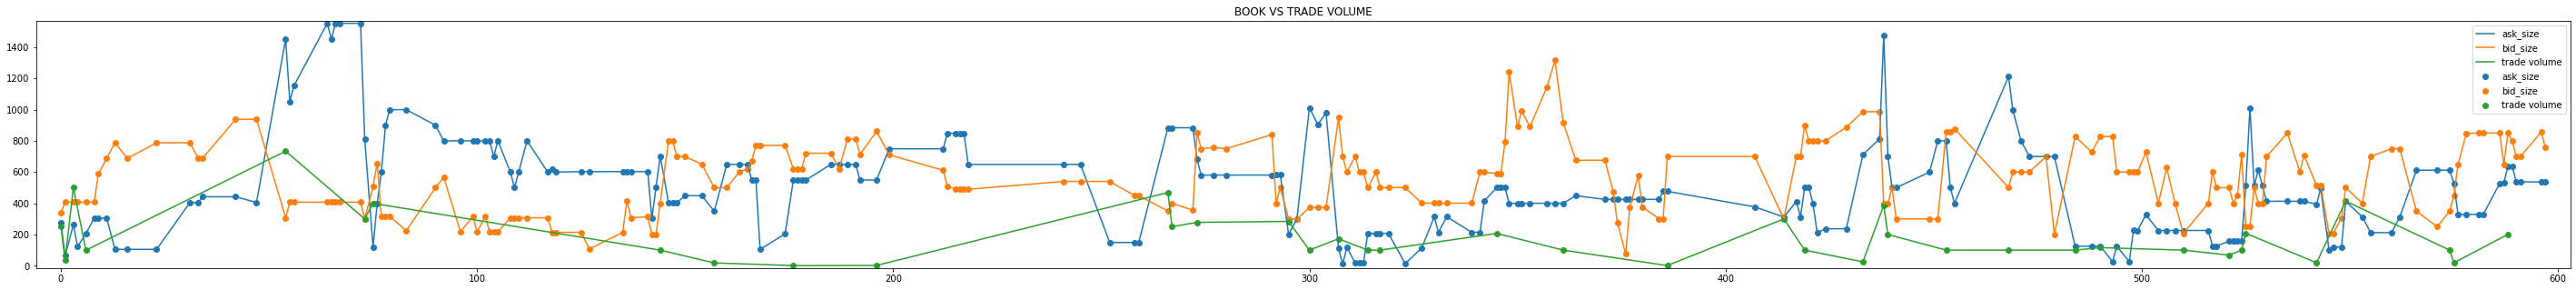

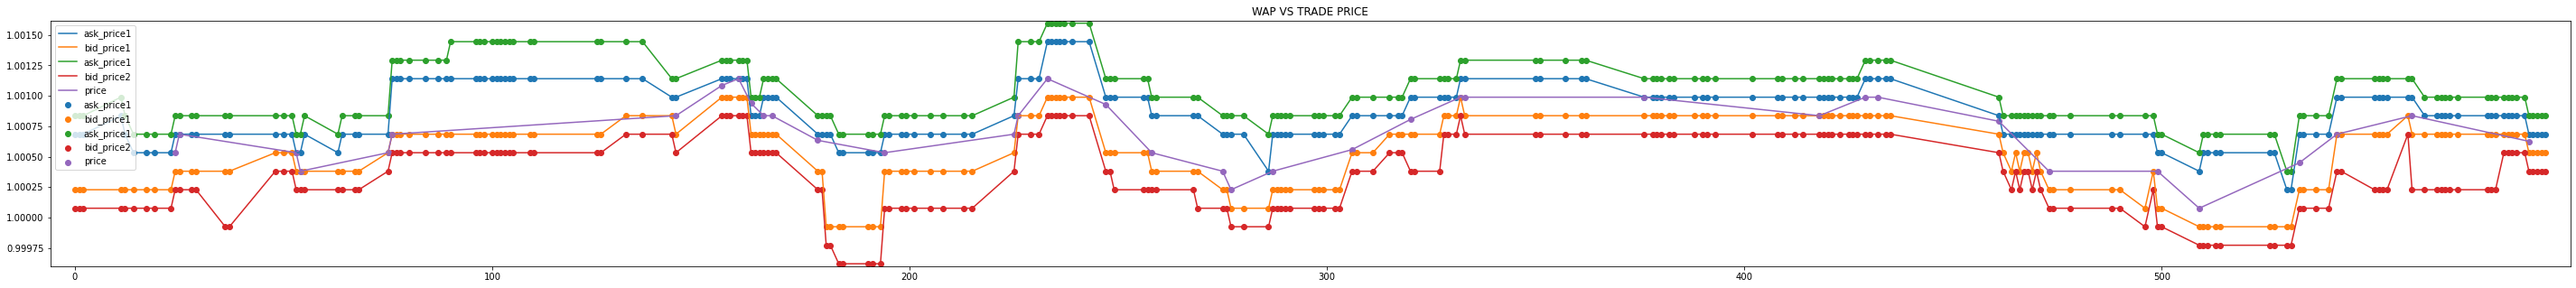

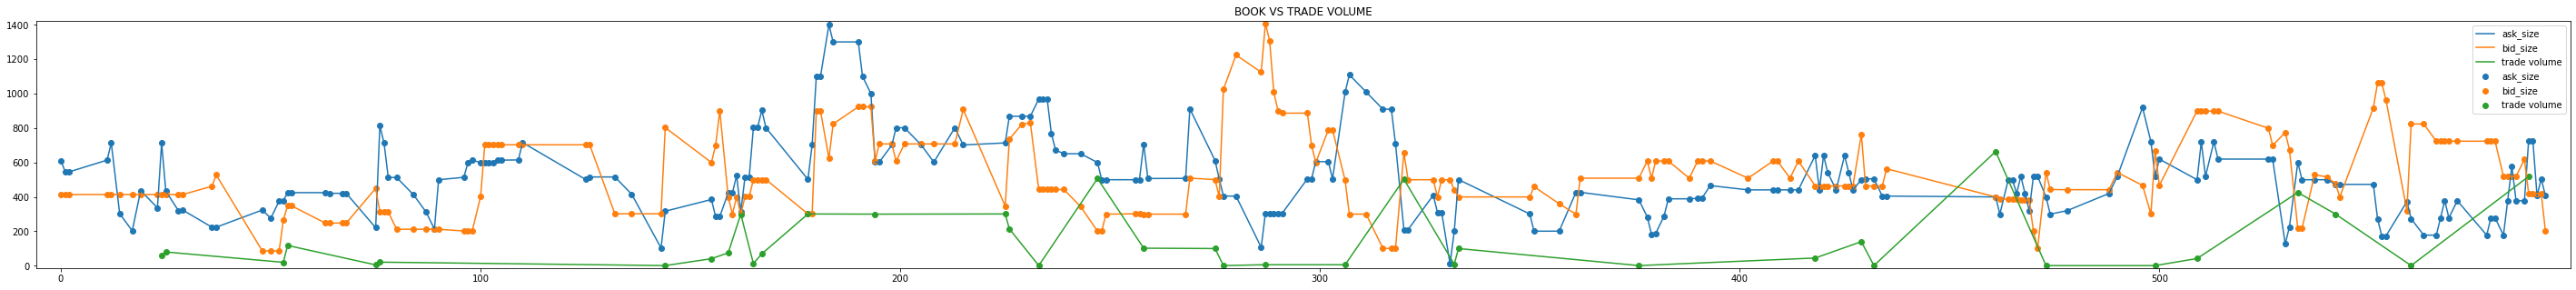

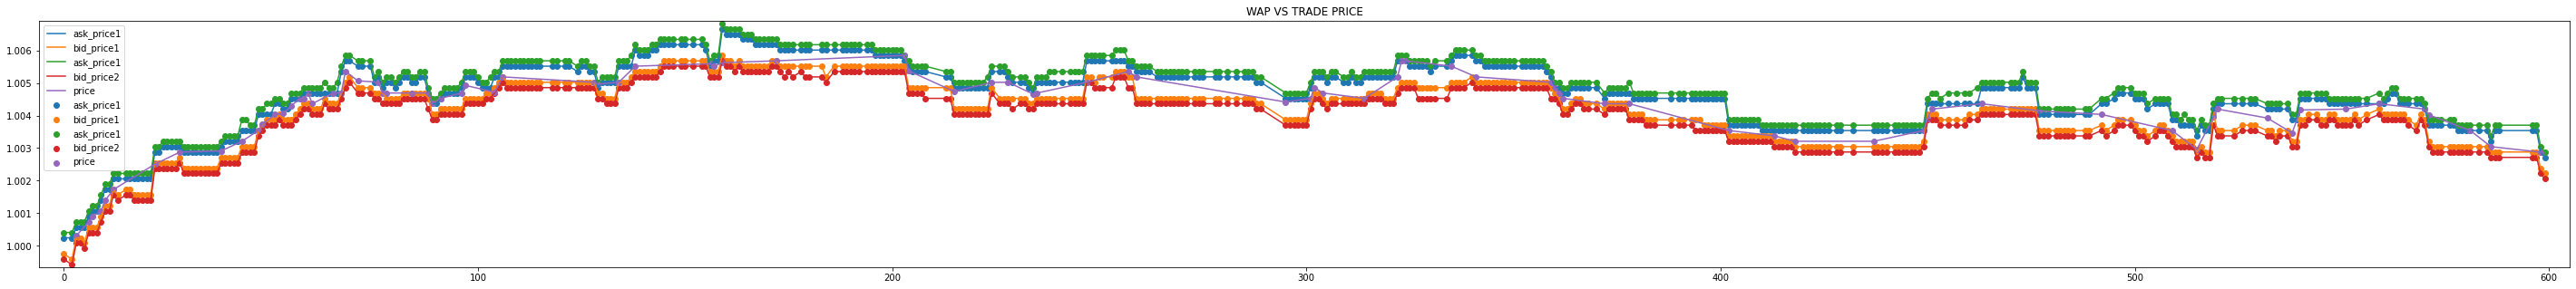

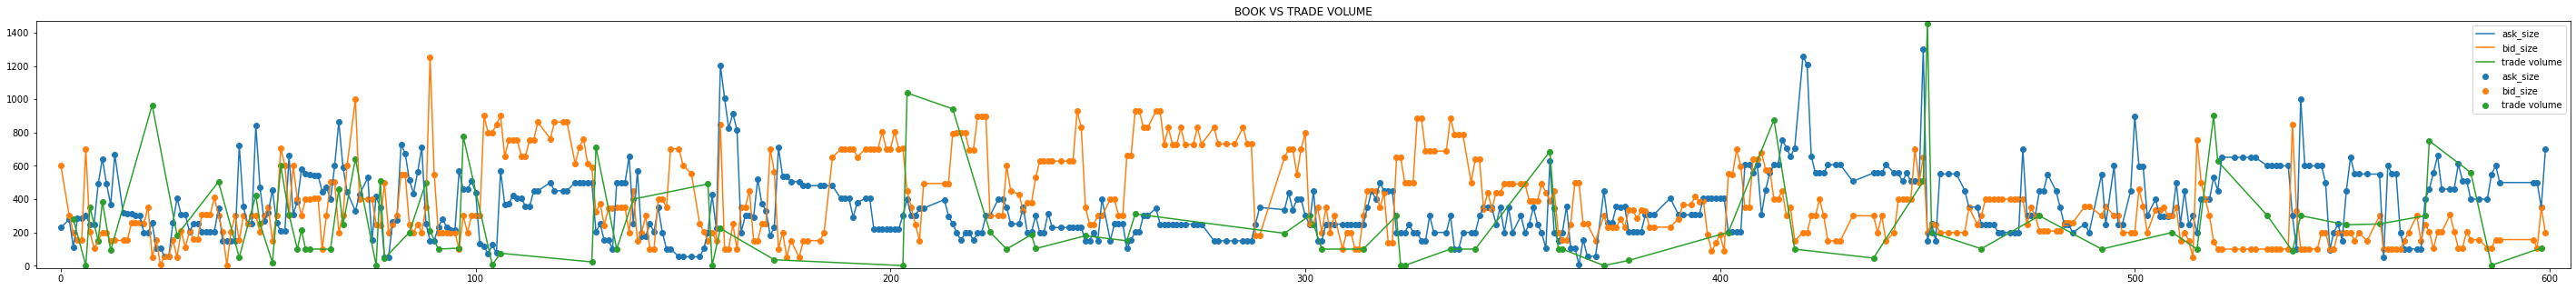

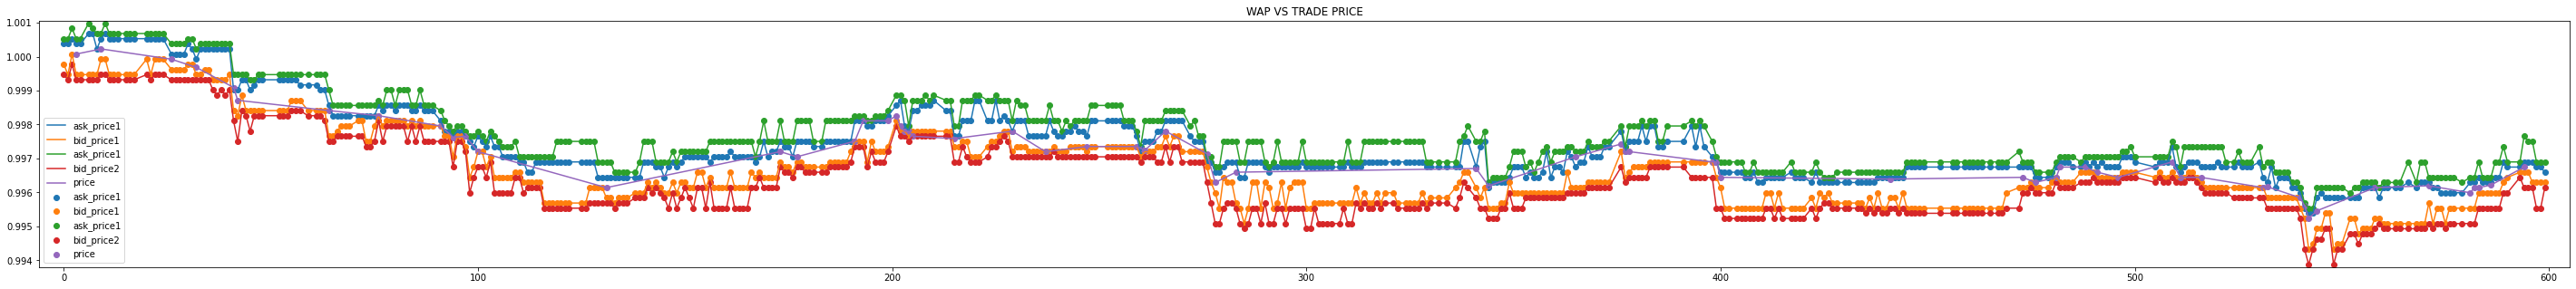

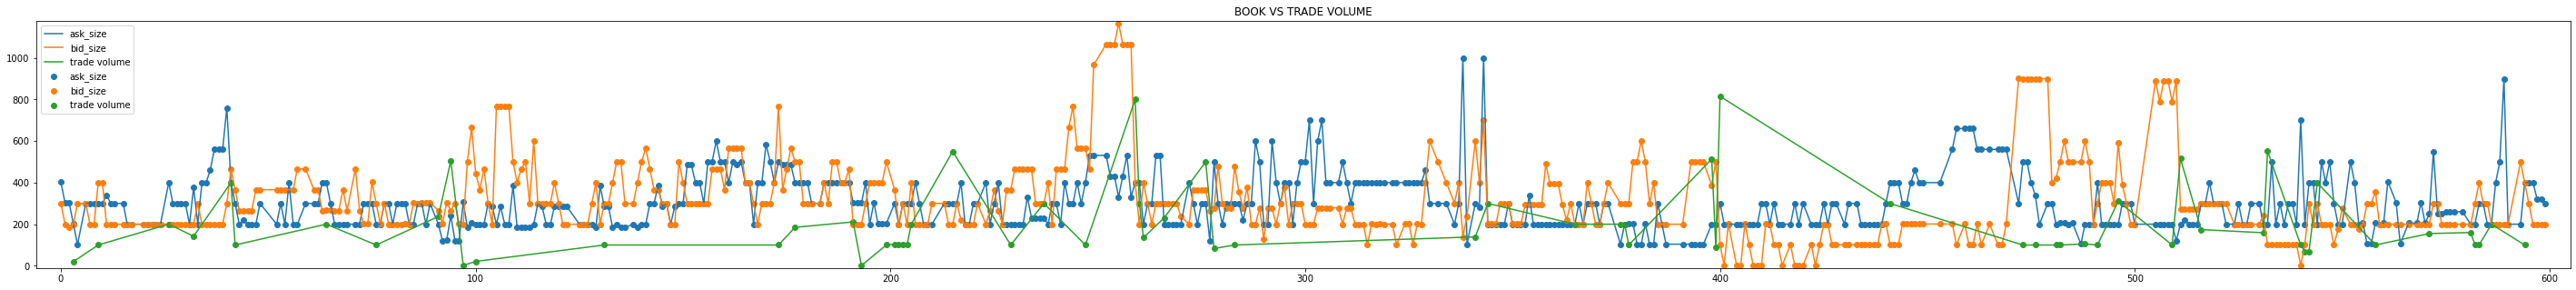

In [20]:
ANALYSIS_WAP_VS_TRADEP_DIR = os.path.join(OUTPUT_DIRECTORY,"ANALYSIS_BOOK_VS_TRADE")
os.makedirs(ANALYSIS_WAP_VS_TRADEP_DIR, exist_ok=True)

timeids = sample_trade_df["time_id"].unique()
populate_wap(sample_book_df)
populate_volume(sample_book_df)

for timeid in timeids[:7]:
    samplebooktime = sample_book_df[sample_book_df['time_id']==timeid]
    sampletradetime = sample_trade_df[sample_trade_df['time_id']==timeid]
    plt.figure(figsize=(50,5))
    plt.margins(x=0.01,y=0.01)
    plt.title("WAP VS TRADE PRICE")
    
    plt.plot(samplebooktime['seconds_in_bucket'], samplebooktime['ask_price1'],label="ask_price1")
    plt.plot(samplebooktime['seconds_in_bucket'], samplebooktime['bid_price1'],label="bid_price1")
    plt.plot(samplebooktime['seconds_in_bucket'], samplebooktime['ask_price2'],label="ask_price1")
    plt.plot(samplebooktime['seconds_in_bucket'], samplebooktime['bid_price2'],label="bid_price2")
    plt.plot(sampletradetime['seconds_in_bucket'], sampletradetime['price'],label="price")
    
    plt.scatter(samplebooktime['seconds_in_bucket'], samplebooktime['ask_price1'],label="ask_price1")
    plt.scatter(samplebooktime['seconds_in_bucket'], samplebooktime['bid_price1'],label="bid_price1")
    plt.scatter(samplebooktime['seconds_in_bucket'], samplebooktime['ask_price2'],label="ask_price1")
    plt.scatter(samplebooktime['seconds_in_bucket'], samplebooktime['bid_price2'],label="bid_price2")
    plt.scatter(sampletradetime['seconds_in_bucket'], sampletradetime['price'],label="price")
    plt.legend()
#     plt.show()
    plt.savefig(os.path.join(ANALYSIS_WAP_VS_TRADEP_DIR,f"{sample_stock_id}-{timeid}_wap_vs_trade.jpg"))
    
    
    plt.figure(figsize=(50,5))
    plt.margins(x=0.01,y=0.01)
    plt.title("BOOK VS TRADE VOLUME")
    plt.plot(samplebooktime['seconds_in_bucket'], samplebooktime['ask_size'],label="ask_size")
    plt.plot(samplebooktime['seconds_in_bucket'], samplebooktime['bid_size'],label="bid_size")
#     plt.plot(samplebooktime['seconds_in_bucket'], samplebooktime['ask_size2'],label="ask_size2")
#     plt.plot(samplebooktime['seconds_in_bucket'], samplebooktime['bid_size2'],label="bid_size2")
    plt.plot(sampletradetime['seconds_in_bucket'], sampletradetime['size'],label="trade volume")
    
    plt.scatter(samplebooktime['seconds_in_bucket'], samplebooktime['ask_size'],label="ask_size")
    plt.scatter(samplebooktime['seconds_in_bucket'], samplebooktime['bid_size'],label="bid_size")
#     plt.scatter(samplebooktime['seconds_in_bucket'], samplebooktime['ask_size2'],label="ask_size2")
#     plt.scatter(samplebooktime['seconds_in_bucket'], samplebooktime['bid_size2'],label="bid_size2")
    plt.scatter(sampletradetime['seconds_in_bucket'], sampletradetime['size'],label="trade volume")
    plt.legend()
    plt.savefig(os.path.join(ANALYSIS_WAP_VS_TRADEP_DIR,f"{sample_stock_id}-{timeid}_book_vs_trade_volume.jpg"))

### Summary: ask volume(sellers) and bid volume affects the price that'll follow in trade;  when orange/ask goes above blue(bid), then the green graph in price goes down slightly
#### - but our goal is not to predict in given time window what will happen to price; rather what'll happen to realized volatility
#### - evenstill we might be able to leverage this phenomenon

### let's sweep through everything once and see how fast we can do that

In [116]:
for groupkey, group_df in train_df.groupby('stock_id'):
    print("STOCK ID: ", groupkey)
    trade_file_loc = os.path.join(TRADE_TRAIN_DIRECTORY, f"stock_id={row['stock_id']:.0f}")
    book_file_loc = os.path.join(BOOK_TRAIN_DIRECTORY, f"stock_id={row['stock_id']:.0f}")
    
    stock_trade_df = pd.read_parquet(trade_file_loc)
    stock_book_df = pd.read_parquet(book_file_loc)
    print("-------", stock_trade_df)
    print("-------", stock_book_df)
    break
    for idx, row in group_df.iterrows():
        stocK_time_trade_df = stock_trade_df[stock_trade_df['time_id']==row['time_id']]
        stocK_time_book_df = stock_book_df[stock_book_df['time_id']==row['time_id']]
#         print(row['time_id'])
#     print(row)

STOCK ID:  0
-------         time_id  seconds_in_bucket     price  size  order_count
0             5                 21  1.002301   326           12
1             5                 46  1.002778   128            4
2             5                 50  1.002818    55            1
3             5                 57  1.003155   121            5
4             5                 68  1.003646     4            1
...         ...                ...       ...   ...          ...
123438    32767                471  0.998659   200            3
123439    32767                517  0.998515    90            1
123440    32767                523  0.998563     1            1
123441    32767                542  0.998803    90            4
123442    32767                567  0.998547   300            3

[123443 rows x 5 columns]
-------         time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  \
0             5                  0    1.001422    1.002301    1.001370   
1             5             

In [102]:
test_df

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [115]:
for groupkey, groupdf in test_df.groupby('stock_id'):
    print("STOCK ID: ", groupkey)
    trade_file_loc = os.path.join(TRADE_TEST_DIRECTORY, f"stock_id={row['stock_id']:.0f}")
    book_file_loc = os.path.join(BOOK_TEST_DIRECTORY, f"stock_id={row['stock_id']:.0f}")
    stock_trade_df = pd.read_parquet(trade_file_loc)
    stock_book_df = pd.read_parquet(book_file_loc)
    print("-------", stock_trade_df)
    print("-------", stock_book_df)
    break
#     for idx, row in groupdf.iterrows():
        

STOCK ID:  0
-------    time_id  seconds_in_bucket     price  size  order_count
0        4                  7  1.000344     1            1
1        4                 24  1.000049   100            7
2        4                 27  1.000059   100            3
-------    time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        4                  0    1.000049    1.000590    0.999656    1.000639   
1        4                  1    1.000049    1.000590    0.999656    1.000639   
2        4                  5    1.000049    1.000639    0.999656    1.000885   

   bid_size1  ask_size1  bid_size2  ask_size2  
0         91        100        100         24  
1         91        100        100         20  
2        290         20        101         15  


## TODO: test data csv and test parquet timeid doesn't match!! there only timeid for in parquet file, what gives?